                    CO2  AvgHigh  AvgLow      NO2       CH4
Year                                                       
1925-01-01          NaN     33.4    17.2      NaN       NaN
1926-01-01          NaN     37.9    21.8      NaN       NaN
1927-01-01          NaN     32.3    15.5      NaN       NaN
1928-01-01          NaN     35.2    18.6      NaN       NaN
1929-01-01          NaN     35.4    19.8      NaN       NaN
...                 ...      ...     ...      ...       ...
2019-01-01  34157534.34     39.5    24.8  16818.0  576504.0
2020-01-01  35915883.53     35.0    20.0  17368.0  518053.0
2021-01-01  39706280.80     33.9    19.0  17234.0  561698.0
2022-01-01  41304340.33     36.1    21.5  17300.0  522819.0
2023-01-01  41304340.33     35.6    21.2  17091.0  506745.0

[99 rows x 5 columns]
ADF Statistic: -0.9043932322280966
P-Value: 0.7865222205164372


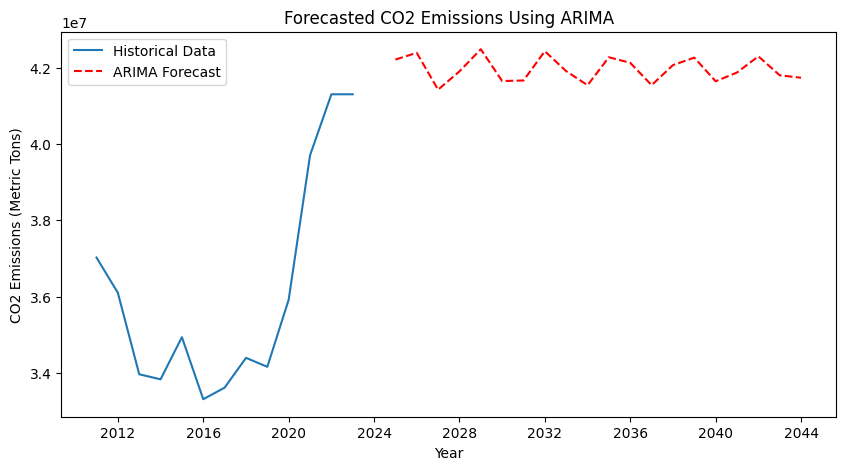

ADF Statistic: -1.9691801839448793
P-Value: 0.30024781470549333


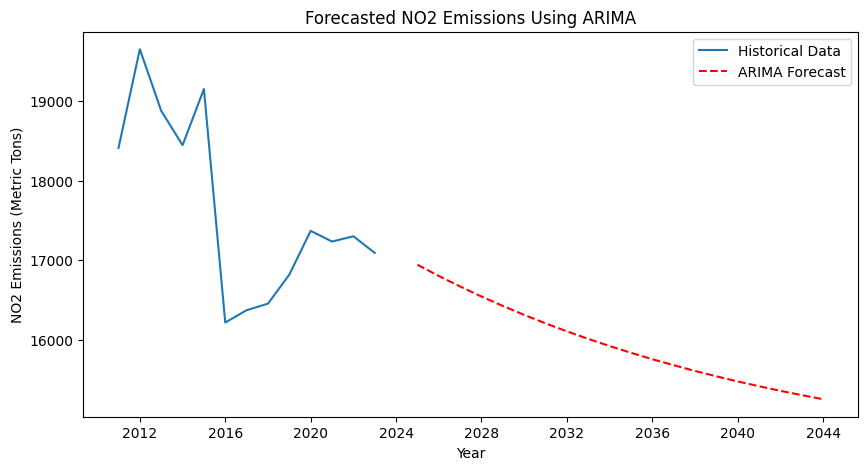

ADF Statistic: -0.8229763890506494
P-Value: 0.8122795912293879


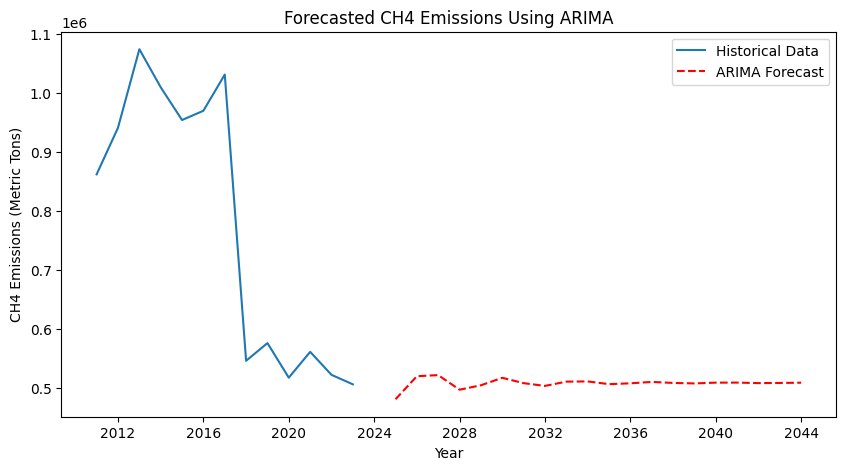

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings("ignore")
# Load the data
df_co2 = pd.read_csv("/content/1CO2.csv")
df_temp = pd.read_csv("/content/1TEMP.csv")
df_no2 = pd.read_csv("/content/1NO2.csv")
df_ch4 = pd.read_csv("/content/1CH4.csv")

# Rename columns for consistency
df_co2.rename(columns={"MetricTons(CO2)": "CO2"}, inplace=True)
df_temp.rename(columns={"AvgHigh(°F)": "AvgHigh", "AvgLow(°F)": "AvgLow"}, inplace=True)
df_no2.rename(columns={"MetricTons(No2)(Co2equivalent)": "NO2"}, inplace=True)
df_ch4.rename(columns={"MetricTons(Ch4)(Co2equivalent)": "CH4"}, inplace=True)


#convert year to a datetime index for co2
df_co2["Year"] = pd.to_datetime(df_co2["Year"], format="%Y")

#convert year to a datetime index for co2
df_temp["Year"] = pd.to_datetime(df_temp["Year"], format="%Y")

#convert year to a datetime index for co2
df_no2["Year"] = pd.to_datetime(df_no2["Year"], format="%Y")

#convert year to a datetime index for co2
df_ch4["Year"] = pd.to_datetime(df_ch4["Year"], format="%Y")

# Merge datasets on 'Year'
df_merged = df_co2.merge(df_temp, on="Year", how="outer") \
                   .merge(df_no2, on="Year", how="outer") \
                   .merge(df_ch4, on="Year", how="outer")

# Fill missing values using forward fill
df_merged.set_index("Year", inplace=True)
df_merged.fillna(method='ffill', inplace=True)

print(df_merged)


def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"P-Value: {result[1]}")
    if result[1] <= 0.05:
        return False
    else:
        return True
#  train and forecast emissions
def train_and_forecast(df, target, regressors, periods=20):
    if check_stationarity(df[target]):
      df_diff = df[target].diff().dropna()

    # Fit the model
    model = ARIMA(df[target], order=(2,1,2))
    model_fit = model.fit()

    # Predict future years
    future_years = periods
    forecast = model_fit.forecast(steps=future_years)

    # create dataframe for future years
    future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(years=1), periods=future_years, freq="Y")
    forecast_df = pd.DataFrame({"Year": future_dates, target: forecast})


    # Plot results
    plt.figure(figsize=(10,5))
    plt.plot(df[target], label="Historical Data")
    plt.plot(forecast_df["Year"], forecast_df[target], linestyle="dashed", color="red", label="ARIMA Forecast")
    plt.xlabel("Year")
    plt.ylabel(f"{target} Emissions (Metric Tons)")
    plt.title(f"Forecasted {target} Emissions Using ARIMA")


    plt.legend()
    plt.show()

    return forecast_df

df_merged.fillna(method='ffill', inplace=True)  # Forward fill missing values
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert inf to NaN
df_merged.dropna(inplace=True)

# Forecast for CO2 emissions
forecast_co2 = train_and_forecast(df_merged, "CO2", ["AvgHigh", "AvgLow"])

# Forecast for NO2 emissions
forecast_no2 = train_and_forecast(df_merged, "NO2", ["AvgHigh", "AvgLow"])

# Forecast for CH4 emissions
forecast_ch4 = train_and_forecast(df_merged, "CH4", ["AvgHigh", "AvgLow"])

# Save results
forecast_co2.to_csv("forecast_co2.csv", index=False)
forecast_no2.to_csv("forecast_no2.csv", index=False)
forecast_ch4.to_csv("forecast_ch4.csv", index=False)